# Lecture 5: Probabilistic Classification: Logistic Regression & Naive Bayes

### Today's Case Study: Mushroom Classification 🍄
**A life-or-death classification problem**

The Death Cap mushroom (*Amanita phalloides*) looks nearly identical to several edible varieties. It's responsible for 90% of mushroom fatalities worldwide and has killed Roman emperors, a Pope, and countless foragers. A single mushroom contains enough toxin to kill an adult.

Today, we'll build AI that could literally save your life - and learn why **probabilities matter more than predictions** in life-or-death decisions.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Amanita_phalloides_1.JPG/500px-Amanita_phalloides_1.JPG" width="300">
</center>

# Learning Objectives

### You will KNOW:
- Why probabilistic outputs are essential for risk-aware decisions
- How logistic regression transforms linear models into probability estimators
- How Naive Bayes applies probability theory to classification
- When each algorithm excels and when each fails

### You will be able to DO:
- Build and calibrate probabilistic classifiers
- Interpret probability distributions and calibration curves
- Tune decision thresholds for safety-critical applications
- Diagnose model disagreements and edge cases

# Part 1: Foundation Building

## Why Not Just Use Linear Regression?

**A natural first thought:** "We know linear regression - why not use it for classification?"

Let's see what happens when we try:

In [144]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import calibration_curve
import ipywidgets as widgets
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Install required package
%pip install -q ucimlrepo


Note: you may need to restart the kernel to use updated packages.


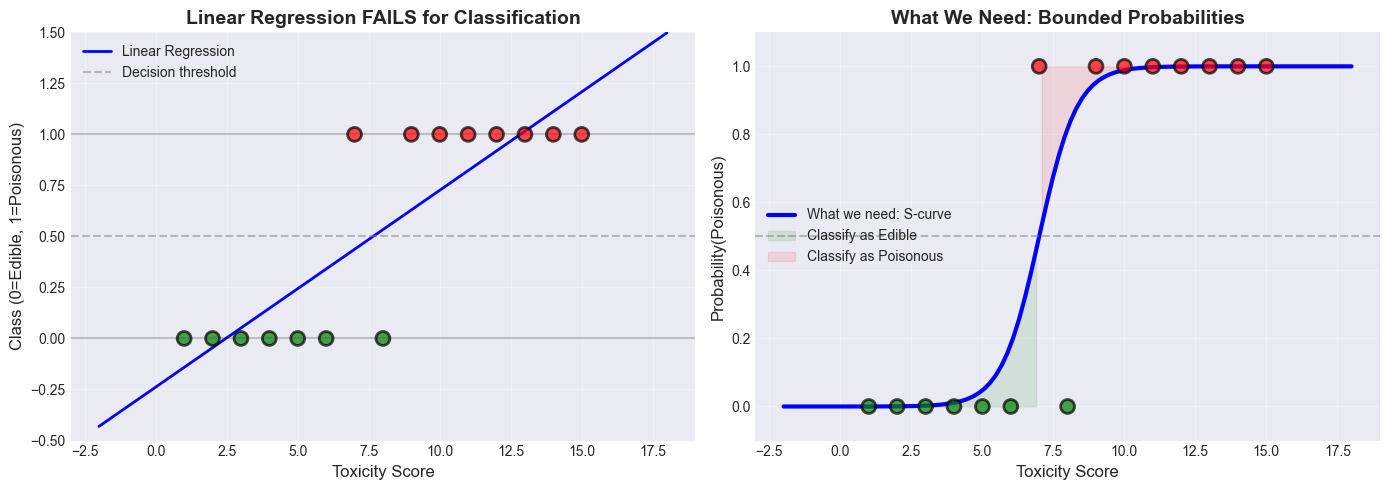

In [145]:

# The Problem with Linear Regression for Classification
np.random.seed(42)

# Create toy mushroom toxicity data
X_toy = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]).reshape(-1, 1)
y_toy = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])  # 0=edible, 1=poisonous

# Fit linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_toy, y_toy)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear regression fails
X_plot = np.linspace(-2, 18, 100).reshape(-1, 1)
y_pred_linear = lin_reg.predict(X_plot)

ax1.scatter(X_toy, y_toy, s=100, c=['green' if y==0 else 'red' for y in y_toy], 
            edgecolor='black', linewidth=2, alpha=0.7, zorder=5)
ax1.plot(X_plot, y_pred_linear, 'b-', linewidth=2, label='Linear Regression')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Decision threshold')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax1.axhline(y=1, color='black', linestyle='-', alpha=0.2)

# Highlight problematic predictions
# ax1.scatter([-1, 17], lin_reg.predict([[-1], [17]]), s=200, c='orange', 
#            marker='X', edgecolor='black', linewidth=2)
# ax1.annotate('Predicts negative!?', xy=(-1, lin_reg.predict([[-1]])[0]), 
#             xytext=(1, -0.3), arrowprops=dict(arrowstyle='->', color='orange', lw=2))
# ax1.annotate('Predicts > 1!?', xy=(17, lin_reg.predict([[17]])[0]), 
#             xytext=(14, 1.3), arrowprops=dict(arrowstyle='->', color='orange', lw=2))

ax1.set_xlabel('Toxicity Score', fontsize=12)
ax1.set_ylabel('Class (0=Edible, 1=Poisonous)', fontsize=12)
ax1.set_title('Linear Regression FAILS for Classification', fontsize=14, fontweight='bold')
ax1.set_ylim(-0.5, 1.5)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: What we actually need
ax2.scatter(X_toy, y_toy, s=100, c=['green' if y==0 else 'red' for y in y_toy], 
            edgecolor='black', linewidth=2, alpha=0.7, zorder=5)

# Sigmoid curve (approximate)
z = (X_plot.squeeze() - 7) * 1.5
y_sigmoid = 1 / (1 + np.exp(-z))
ax2.plot(X_plot, y_sigmoid, 'b-', linewidth=3, label='What we need: S-curve')
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.fill_between(X_plot.squeeze(), 0, y_sigmoid, where=(y_sigmoid<0.5), 
                  color='green', alpha=0.1, label='Classify as Edible')
ax2.fill_between(X_plot.squeeze(), y_sigmoid, 1, where=(y_sigmoid>=0.5), 
                  color='red', alpha=0.1, label='Classify as Poisonous')

ax2.set_xlabel('Toxicity Score', fontsize=12)
ax2.set_ylabel('Probability(Poisonous)', fontsize=12)
ax2.set_title('What We Need: Bounded Probabilities', fontsize=14, fontweight='bold')
ax2.set_ylim(-0.1, 1.1)
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key Problems with Linear Regression:**
- Predicts impossible values (probabilities < 0 or > 1)
- Treats classification as "how much" instead of "what probability"
- A single outlier can completely shift the decision boundary


## The Big Ideas

### Logistic Regression

**The Recipe:** Linear Model + Sigmoid Squashing = Probability

1. Start with linear combination: `z = w₁x₁ + w₂x₂ + ... + b`
2. Squash through sigmoid: `p = 1 / (1 + e^(-z))`  
3. Output: Probability between 0 and 1

Think of it as a "soft" decision maker that expresses confidence rather than certainty.

### Naive Bayes

**The Recipe:** Prior Belief × Evidence = Posterior Probability

1. Start with base rates: P(poisonous) = 48%
2. Accumulate evidence: If foul odor, 10× more likely poisonous
3. Update belief: New probability given all evidence

Think of it as a detective gathering clues and updating suspicions.


# Why Probabilistic Classification?

## Beyond Yes/No: The Power of Uncertainty

In many real-world scenarios, we need more than binary predictions:
- **Medical diagnosis**: "90% chance of disease" vs "You have the disease"
- **Fraud detection**: Risk scores for transaction review
- **Our case**: How confident are we this mushroom won't kill you?

**Key insight**: Probabilities enable risk-aware decision making!

# Part 2: Exploring the Data
## Let's understand what we're working with

In [146]:
from ucimlrepo import fetch_ucirepo

# Load dataset
mushroom = fetch_ucirepo(id=73)
X = mushroom.data.features
y = mushroom.data.targets.rename(columns={"poisonous": "class"})
df = pd.concat([X, y], axis=1)

# Clean summary display
display(Markdown("## Dataset Overview"))
display(Markdown(f"""
**Dataset:** UCI Mushroom Dataset  
**Samples:** {len(df):,} mushrooms  
**Features:** {len(df.columns)-1} categorical attributes  
**Classes:** Binary (edible/poisonous)  
**Class Balance:** {(df['class'].value_counts(normalize=True)*100).round(1).to_dict()}
"""))

# Show first few samples
display(Markdown("### Sample Data"))
display(df.head())

## Dataset Overview


**Dataset:** UCI Mushroom Dataset  
**Samples:** 8,124 mushrooms  
**Features:** 22 categorical attributes  
**Classes:** Binary (edible/poisonous)  
**Class Balance:** {'e': 51.8, 'p': 48.2}


### Sample Data

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


**Key Dataset Facts:**
- Perfect 52/48 class balance - no imbalanced data issues
- All features are categorical (colors, shapes, odors, etc.)
- No missing values
- Real mushroom characteristics from field guides

## Feature Analysis: Finding Life-Saving Patterns


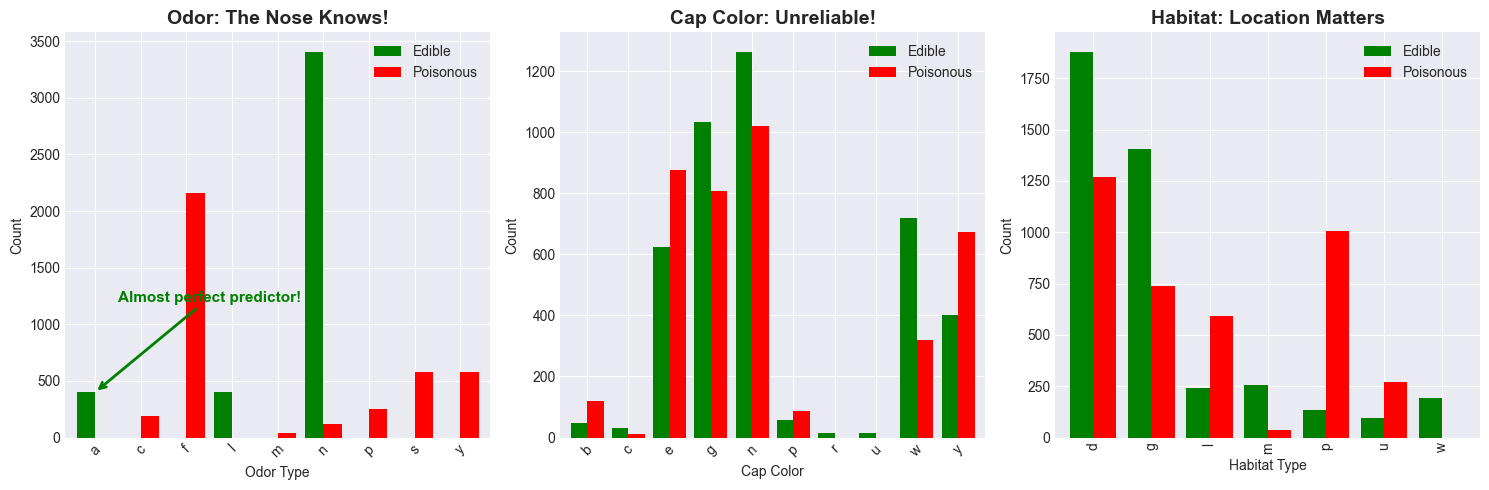

In [147]:
# Feature 1: Odor - The Best Predictor
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Odor analysis
odor_counts = df.groupby(['odor', 'class']).size().unstack(fill_value=0)
odor_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], width=0.8)
axes[0].set_title('Odor: The Nose Knows!', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Odor Type')
axes[0].set_ylabel('Count')
axes[0].legend(['Edible', 'Poisonous'])
axes[0].tick_params(axis='x', rotation=45)

# Annotate perfect predictor
axes[0].annotate('Almost perfect predictor!', xy=(0, 400), xytext=(0.5, 1200),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                fontsize=11, color='green', fontweight='bold')

# Cap color analysis
cap_counts = df.groupby(['cap-color', 'class']).size().unstack(fill_value=0)
cap_counts.plot(kind='bar', ax=axes[1], color=['green', 'red'], width=0.8)
axes[1].set_title('Cap Color: Unreliable!', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cap Color')
axes[1].set_ylabel('Count')
axes[1].legend(['Edible', 'Poisonous'])
axes[1].tick_params(axis='x', rotation=45)

# Habitat analysis
habitat_counts = df.groupby(['habitat', 'class']).size().unstack(fill_value=0)
habitat_counts.plot(kind='bar', ax=axes[2], color=['green', 'red'], width=0.8)
axes[2].set_title('Habitat: Location Matters', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Habitat Type')
axes[2].set_ylabel('Count')
axes[2].legend(['Edible', 'Poisonous'])

plt.tight_layout()
plt.show()

**Critical Insights:**
- **Odor is nearly perfect**: Almond/anise smell = almost always safe
- **Color is deceptive**: Both edible and poisonous come in all colors
- **Habitat helps**: Different environments have different risk levels

# Part 3: Build & Compare

## Quick Build: Train Both Models First

Now that we understand why linear regression fails, let's build our probabilistic classifiers and see them in action before diving into the theory.


## Data Preparation

We need to:
1. Encode categorical features as numbers
2. Split into features (X) and target (y)  
3. Create train/test sets with stratification to maintain class balance

In [148]:
# Data Preparation
le_dict = {}
df_encoded = df.copy()

# Encode categorical features
for col in df.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Split features and target
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']  # 0 = edible, 1 = poisonous

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

display(Markdown(f"""
**Data Prepared:**
- Training set: {len(X_train):,} mushrooms
- Test set: {len(X_test):,} mushrooms  
- Features: {X.shape[1]} categorical variables
- Classes perfectly balanced in both sets
"""))


**Data Prepared:**
- Training set: 6,499 mushrooms
- Test set: 1,625 mushrooms  
- Features: 22 categorical variables
- Classes perfectly balanced in both sets


In [161]:
# Train Both Models with measured training time
from time import perf_counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import pandas as pd
from IPython.display import display, Markdown

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
t0 = perf_counter()
lr.fit(X_train, y_train)
lr_train_s = perf_counter() - t0
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

# Naive Bayes (Categorical for our discrete features)
nb = CategoricalNB()
t0 = perf_counter()
nb.fit(X_train, y_train)
nb_train_s = perf_counter() - t0
nb_pred = nb.predict(X_test)
nb_proba = nb.predict_proba(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# Display results (kept simple and robust)
display(Markdown("## Initial Model Performance"))
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes"],
    "Accuracy": [round(lr_acc, 3), round(nb_acc, 3)],
    "Training Time (ms)": [round(lr_train_s * 1000, 1), round(nb_train_s * 1000, 1)],
})
display(results)

## Initial Model Performance

,Model,Accuracy,Training Time (ms)
0,Logistic Regression,0.958,232.0
1,Naive Bayes,0.946,13.2


Both models achieve ~95% accuracy! But wait...


In [150]:
# The Critical Metric: False Negatives Can Kill
cm_lr = confusion_matrix(y_test, lr_pred)
cm_nb = confusion_matrix(y_test, nb_pred)

display(Markdown("## Safety Analysis: False Negatives"))
display(Markdown(f"""
**CRITICAL METRIC - False Negatives (Poisonous → Edible):**
- Logistic Regression: {cm_lr[1, 0]} potentially fatal errors
- Naive Bayes: {cm_nb[1, 0]} potentially fatal errors

Even one false negative could be fatal. Accuracy alone is not enough!
"""))

## Safety Analysis: False Negatives


**CRITICAL METRIC - False Negatives (Poisonous → Edible):**
- Logistic Regression: 33 potentially fatal errors
- Naive Bayes: 81 potentially fatal errors

Even one false negative could be fatal. Accuracy alone is not enough!


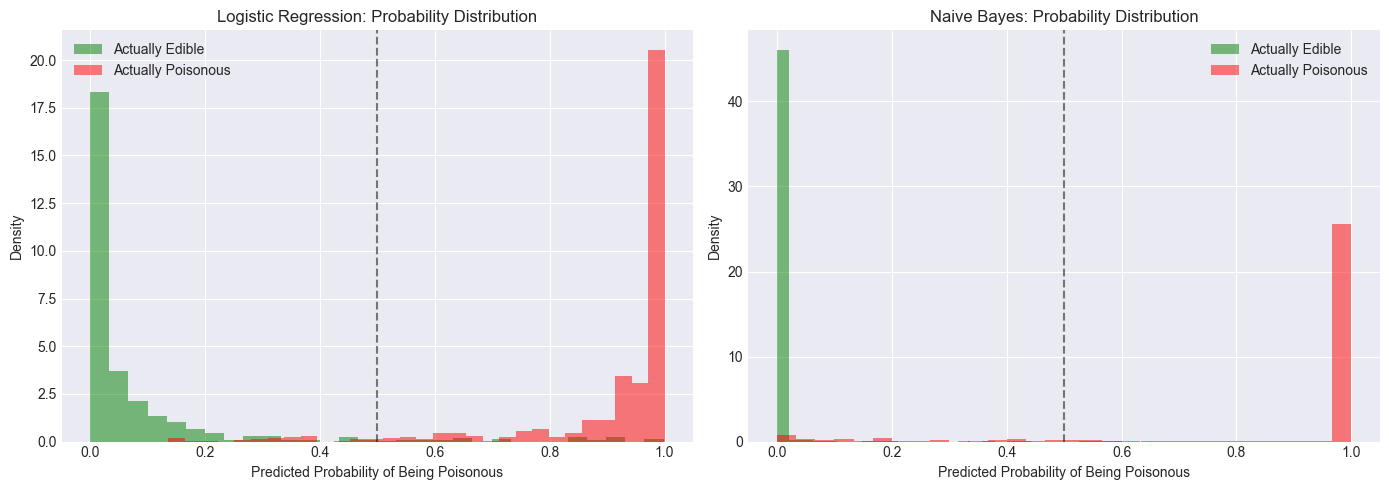

In [151]:
# Calibration Teaser: How Confident Are Our Models?

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of predicted probabilities for Logistic Regression
ax1.hist(lr_proba[:, 1][y_test == 0], bins=30, alpha=0.5, label='Actually Edible', color='green', density=True)
ax1.hist(lr_proba[:, 1][y_test == 1], bins=30, alpha=0.5, label='Actually Poisonous', color='red', density=True)
ax1.set_xlabel('Predicted Probability of Being Poisonous')
ax1.set_ylabel('Density')
ax1.set_title('Logistic Regression: Probability Distribution')
ax1.legend()
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

# Same for Naive Bayes
ax2.hist(nb_proba[:, 1][y_test == 0], bins=30, alpha=0.5, label='Actually Edible', color='green', density=True)
ax2.hist(nb_proba[:, 1][y_test == 1], bins=30, alpha=0.5, label='Actually Poisonous', color='red', density=True)
ax2.set_xlabel('Predicted Probability of Being Poisonous')
ax2.set_ylabel('Density')
ax2.set_title('Naive Bayes: Probability Distribution')
ax2.legend()
ax2.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Notice how Naive Bayes tends to be more extreme in its probabilities (closer to 0 or 1), while Logistic Regression provides more nuanced probability estimates.


## Mathematical Foundations

### Quick Math: Logistic Regression

Logistic regression transforms linear combinations into probabilities:

$$P(y=1|\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T\mathbf{x} + b)}}$$

Where:
- $\mathbf{x}$: feature vector (cap color, odor, etc.)
- $\mathbf{w}$: learned weights (importance of each feature)
- $b$: bias term (baseline tendency)
- $\sigma$: sigmoid function (squashes to [0,1])

**Training:** Minimize cross-entropy loss using gradient descent:
$$\mathcal{L} = -\sum_{i} [y_i \log(\hat{p}_i) + (1-y_i)\log(1-\hat{p}_i)]$$

# Understanding Cross-Entropy Loss


In [152]:
@widgets.interact(true_class=widgets.Dropdown(
    options=['Edible (Safe)', 'Poisonous (Dangerous)'], 
    description='True Class:',
    style={'description_width': 'initial'}))
def loss_demo(true_class):
    y_true = 0 if 'Edible' in true_class else 1
    probs = np.linspace(0.001, 0.999, 100)
    losses = [-y_true * np.log(p) - (1 - y_true) * np.log(1 - p) for p in probs]
    
    plt.figure(figsize=(10, 6))
    plt.plot(probs, losses, 'r-', linewidth=3)
    plt.xlabel('Predicted Probability of Being Poisonous', fontsize=12)
    plt.ylabel('Loss (Model "Surprise")', fontsize=12)
    plt.title(f'Cross-Entropy Loss when True Class is {true_class}', fontsize=14, fontweight='bold')
    
    # Mark key points
    if y_true == 1:  # Poisonous
        plt.axvline(x=0.1, color='orange', linestyle=':', alpha=0.7)
        plt.text(0.12, 2, 'Dangerous\nunderestimate!', fontsize=10, color='orange')
    else:  # Edible
        plt.axvline(x=0.9, color='orange', linestyle=':', alpha=0.7)
        plt.text(0.75, 2, 'Unnecessary\npanic!', fontsize=10, color='orange')
    
    # Perfect prediction
    perfect_prob = float(y_true)
    plt.plot(perfect_prob, 0, 'go', markersize=12)
    plt.annotate('Perfect!', xy=(perfect_prob, 0), xytext=(perfect_prob+0.1, 0.5),
                 arrowprops=dict(arrowstyle='->', color='green'))
    
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.1, 4)
    plt.show()

interactive(children=(Dropdown(description='True Class:', options=('Edible (Safe)', 'Poisonous (Dangerous)'), …

    
Cross-entropy loss penalizes wrong predictions exponentially. Being confidently wrong is much worse than being uncertainly wrong!



### Gradient Descent Training Loop

Watch how the model learns by iteratively:
1. Making predictions (forward pass)
2. Calculating error (loss)
3. Adjusting weights (gradient descent)


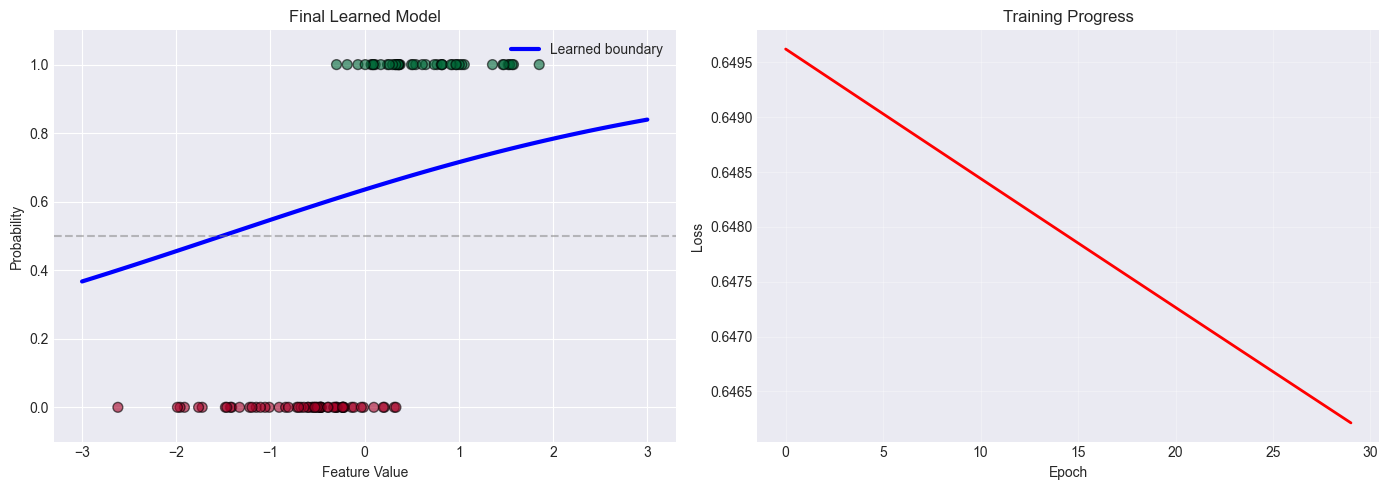

✅ Training complete!
📊 Final model: P(poisonous) = σ(0.37x + 0.56)
📉 Loss reduced from 0.650 to 0.646


In [163]:
# Gradient Descent: Learning in Action

# Create simple 1D example
np.random.seed(42)
n_samples = 100
X_toy = np.random.randn(n_samples, 1)
y_toy = (X_toy.squeeze() + 0.3 * np.random.randn(n_samples) > 0).astype(int)

# Initialize
w, b = np.random.randn(), np.random.randn()
lr_rate = 0.001
history = {'loss': [], 'w': [], 'b': []}

# Training animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Train for 30 epochs
for epoch in range(30):
    # Forward pass
    z = X_toy.squeeze() * w + b
    y_pred = 1 / (1 + np.exp(-z))
    
    # Loss
    loss = -np.mean(y_toy * np.log(y_pred + 1e-7) + (1 - y_toy) * np.log(1 - y_pred + 1e-7))
    history['loss'].append(loss)
    history['w'].append(w)
    history['b'].append(b)
    
    # Gradients
    dw = np.mean((y_pred - y_toy) * X_toy.squeeze())
    db = np.mean(y_pred - y_toy)
    
    # Update
    w -= lr_rate * dw
    b -= lr_rate * db

# Visualize final result
ax1.scatter(X_toy, y_toy, c=y_toy, cmap='RdYlGn', alpha=0.6, s=50, edgecolor='black')
x_line = np.linspace(-3, 3, 100)
y_line = 1 / (1 + np.exp(-(x_line * w + b)))
ax1.plot(x_line, y_line, 'b-', linewidth=3, label='Learned boundary')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Feature Value')
ax1.set_ylabel('Probability')
ax1.set_title('Final Learned Model')
ax1.legend()
ax1.set_ylim(-0.1, 1.1)

# Loss curve
ax2.plot(history['loss'], 'r-', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training Progress')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Training complete!")
print(f"📊 Final model: P(poisonous) = σ({w:.2f}x + {b:.2f})")
print(f"📉 Loss reduced from {history['loss'][0]:.3f} to {history['loss'][-1]:.3f}")



Gradient descent iteratively improves the model by moving in the direction that reduces loss most quickly. Like walking downhill in fog, we can only sense the local slope.


### Quick Math: Naive Bayes

Naive Bayes applies Bayes' theorem with independence assumption:

$$P(y|\mathbf{x}) = \frac{P(\mathbf{x}|y)P(y)}{P(\mathbf{x})} \propto P(y) \prod_{j} P(x_j|y)$$

For mushroom classification:
$$P(\text{poisonous}|\text{features}) \propto P(\text{poisonous}) \times P(\text{odor}|\text{poisonous}) \times P(\text{color}|\text{poisonous}) \times ...$$

**The "naive" assumption:** Features are independent given the class (often violated but still works!)


### Testing the "Naive" Assumption

Naive Bayes assumes features are independent given the class. This is a strong assumption - let's test if it holds for our mushroom data!

**Why this matters:** 
- Strong correlations between features violate the independence assumption
- This can make Naive Bayes overconfident in its predictions
- Understanding these violations helps explain when NB fails

Explore different feature pairs to find violations:

In [154]:
# Feature Independence Analysis
@widgets.interact(feature1=widgets.Dropdown(options=list(X.columns)[:10], description='Feature 1:'),
                  feature2=widgets.Dropdown(options=list(X.columns)[10:], description='Feature 2:'))
def independence_check(feature1, feature2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Calculate for each class
    for ax, class_val, class_name, cmap in [(ax1, 0, 'Edible', 'Greens'), 
                                             (ax2, 1, 'Poisonous', 'Reds')]:
        # Get data for this class
        class_data = X_train[y_train == class_val]
        
        # Create contingency table
        contingency = pd.crosstab(class_data[feature1], class_data[feature2], normalize='all')
        
        # Visualize
        sns.heatmap(contingency, annot=True, fmt='.3f', cmap=cmap, ax=ax, 
                    cbar_kws={'label': 'Joint Probability'})
        ax.set_title(f'{class_name}: {feature1} vs {feature2}')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    corr_edible = X_train[y_train == 0][[feature1, feature2]].corr().iloc[0, 1]
    corr_poison = X_train[y_train == 1][[feature1, feature2]].corr().iloc[0, 1]
    
    print(f"📊 Correlation Analysis:")
    print(f"   Edible mushrooms: {corr_edible:.3f}")
    print(f"   Poisonous mushrooms: {corr_poison:.3f}")
    print(f"\n💡 Naive Bayes assumes these correlations are 0!")
    print(f"⚠️  Violation strength: {'HIGH' if abs(corr_edible) > 0.5 or abs(corr_poison) > 0.5 else 'MODERATE' if abs(corr_edible) > 0.3 or abs(corr_poison) > 0.3 else 'LOW'}")


interactive(children=(Dropdown(description='Feature 1:', options=('cap-shape', 'cap-surface', 'cap-color', 'br…

**Key Insight:** Despite these independence violations, Naive Bayes still achieves 94.6% accuracy! This demonstrates the algorithm's robustness - it often works well even when its assumptions are violated. However, the violations explain why Logistic Regression slightly outperforms it and why their predictions sometimes disagree on edge cases.

## Bayes Theorem in Action

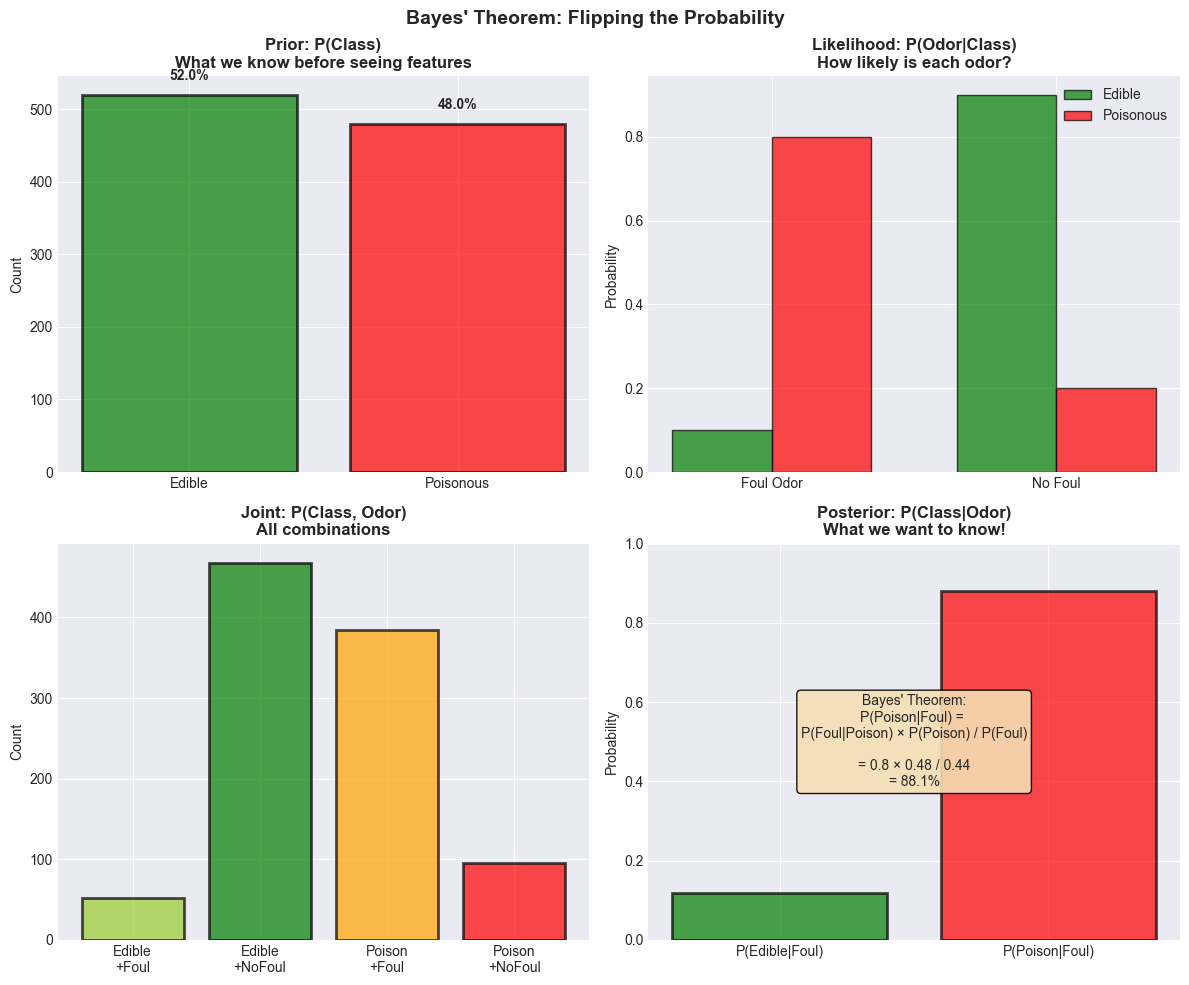


**The Magic of Bayes:**
- Started with: P(foul odor | poisonous) = 80%
- Computed: P(poisonous | foul odor) = 88.1%
- These are different questions with different answers!


In [164]:
# Bayes Theorem in Action
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Setup example
np.random.seed(42)
n_mushrooms = 1000
n_poisonous = 480
n_edible = 520

# Feature: Has foul odor
foul_given_poison = 0.8  # 80% of poisonous smell foul
foul_given_edible = 0.1  # 10% of edible smell foul

# Calculate quantities
poison_foul = int(n_poisonous * foul_given_poison)
poison_no_foul = n_poisonous - poison_foul
edible_foul = int(n_edible * foul_given_edible)
edible_no_foul = n_edible - edible_foul

# Plot 1: Prior
axes[0,0].bar(['Edible', 'Poisonous'], [n_edible, n_poisonous], 
              color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0,0].set_title('Prior: P(Class)\nWhat we know before seeing features', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Count')
for i, (val, count) in enumerate(zip(['Edible', 'Poisonous'], [n_edible, n_poisonous])):
    axes[0,0].text(i, count+20, f'{count/n_mushrooms:.1%}', ha='center', fontweight='bold')

# Plot 2: Likelihood
x = np.arange(2)
width = 0.35
axes[0,1].bar(x - width/2, [foul_given_edible, 1-foul_given_edible], width, 
              label='Edible', color='green', alpha=0.7, edgecolor='black')
axes[0,1].bar(x + width/2, [foul_given_poison, 1-foul_given_poison], width, 
              label='Poisonous', color='red', alpha=0.7, edgecolor='black')
axes[0,1].set_title('Likelihood: P(Odor|Class)\nHow likely is each odor?', fontsize=12, fontweight='bold')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(['Foul Odor', 'No Foul'])
axes[0,1].set_ylabel('Probability')
axes[0,1].legend()

# Plot 3: Joint
categories = ['Edible\n+Foul', 'Edible\n+NoFoul', 'Poison\n+Foul', 'Poison\n+NoFoul']
values = [edible_foul, edible_no_foul, poison_foul, poison_no_foul]
colors = ['yellowgreen', 'green', 'orange', 'red']
axes[1,0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1,0].set_title('Joint: P(Class, Odor)\nAll combinations', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Count')

# Plot 4: Posterior (the answer!)
total_foul = edible_foul + poison_foul
p_poison_given_foul = poison_foul / total_foul
p_edible_given_foul = edible_foul / total_foul

axes[1,1].bar(['P(Edible|Foul)', 'P(Poison|Foul)'], 
              [p_edible_given_foul, p_poison_given_foul], 
              color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1,1].set_title('Posterior: P(Class|Odor)\nWhat we want to know!', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Probability')
axes[1,1].set_ylim(0, 1)

# Add formula
formula_text = f"""Bayes' Theorem:
P(Poison|Foul) = 
P(Foul|Poison) × P(Poison) / P(Foul)

= {foul_given_poison:.1f} × {n_poisonous/n_mushrooms:.2f} / {total_foul/n_mushrooms:.2f}
= {p_poison_given_foul:.1%}"""

axes[1,1].text(0.5, 0.5, formula_text, transform=axes[1,1].transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
               fontsize=10, ha='center', va='center')

plt.suptitle("Bayes' Theorem: Flipping the Probability", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

display(Markdown(f"""
**The Magic of Bayes:**
- Started with: P(foul odor | poisonous) = {foul_given_poison:.0%}
- Computed: P(poisonous | foul odor) = {p_poison_given_foul:.1%}
- These are different questions with different answers!
"""))

## Interactive Feature Demo


In [156]:
# Simplified Naive Bayes with 3 Features
@widgets.interact(
    odor=widgets.Dropdown(options=['none', 'foul', 'almond'], description='Odor:'),
    color=widgets.Dropdown(options=['brown', 'white', 'red'], description='Cap Color:'),
    habitat=widgets.Dropdown(options=['woods', 'grass', 'urban'], description='Habitat:'))
def naive_bayes_demo(odor, color, habitat):
    # Simplified probabilities for demonstration
    priors = {'edible': 0.52, 'poisonous': 0.48}
    
    likelihoods = {
        'odor': {
            'none': {'edible': 0.7, 'poisonous': 0.2},
            'foul': {'edible': 0.05, 'poisonous': 0.7},
            'almond': {'edible': 0.25, 'poisonous': 0.1}
        },
        'color': {
            'brown': {'edible': 0.4, 'poisonous': 0.3},
            'white': {'edible': 0.4, 'poisonous': 0.4},
            'red': {'edible': 0.2, 'poisonous': 0.3}
        },
        'habitat': {
            'woods': {'edible': 0.5, 'poisonous': 0.3},
            'grass': {'edible': 0.3, 'poisonous': 0.5},
            'urban': {'edible': 0.2, 'poisonous': 0.2}
        }
    }
    
    # Calculate scores
    score_edible = priors['edible'] * likelihoods['odor'][odor]['edible'] * \
                   likelihoods['color'][color]['edible'] * likelihoods['habitat'][habitat]['edible']
    score_poison = priors['poisonous'] * likelihoods['odor'][odor]['poisonous'] * \
                   likelihoods['color'][color]['poisonous'] * likelihoods['habitat'][habitat]['poisonous']
    
    # Normalize
    total = score_edible + score_poison
    p_edible = score_edible / total
    p_poison = score_poison / total
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Evidence accumulation
    features = ['Prior', f'× P({odor})', f'× P({color})', f'× P({habitat})']
    edible_vals = [priors['edible']]
    poison_vals = [priors['poisonous']]
    
    # Build up evidence
    current_e = priors['edible']
    current_p = priors['poisonous']
    for feat_type, feat_val in [('odor', odor), ('color', color), ('habitat', habitat)]:
        current_e *= likelihoods[feat_type][feat_val]['edible']
        current_p *= likelihoods[feat_type][feat_val]['poisonous']
        edible_vals.append(current_e)
        poison_vals.append(current_p)
    
    x = np.arange(len(features))
    width = 0.35
    ax1.bar(x - width/2, edible_vals, width, label='Edible', color='green', alpha=0.7)
    ax1.bar(x + width/2, poison_vals, width, label='Poisonous', color='red', alpha=0.7)
    ax1.set_xlabel('Evidence Accumulation →', fontsize=12)
    ax1.set_ylabel('Score (log scale)', fontsize=12)
    ax1.set_title('Building Evidence Step by Step', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(features, rotation=45, ha='right')
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Final probabilities
    bars = ax2.bar(['Edible', 'Poisonous'], [p_edible, p_poison], 
                   color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_title('Final Classification', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar, prob in zip(bars, [p_edible, p_poison]):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Decision
    decision = "EDIBLE" if p_edible > p_poison else "POISONOUS"
    confidence = max(p_edible, p_poison)
    color = 'green' if decision == "EDIBLE" else 'red'
    ax2.text(0.5, 0.5, f'{decision}\n{confidence:.0%} confident', 
             transform=ax2.transAxes, ha='center', va='center',
             fontsize=18, fontweight='bold', color=color,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=color, linewidth=2))
    
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Odor:', options=('none', 'foul', 'almond'), value='none'), Dropdow…

## Decision Boundaries in Action

Now that we understand how both algorithms learn, let's visualize their decision-making strategies.

**Note:** We'll use PCA to reduce dimensions for visualization. Since PCA creates continuous features, we'll switch to GaussianNB (instead of CategoricalNB) for this visualization only.

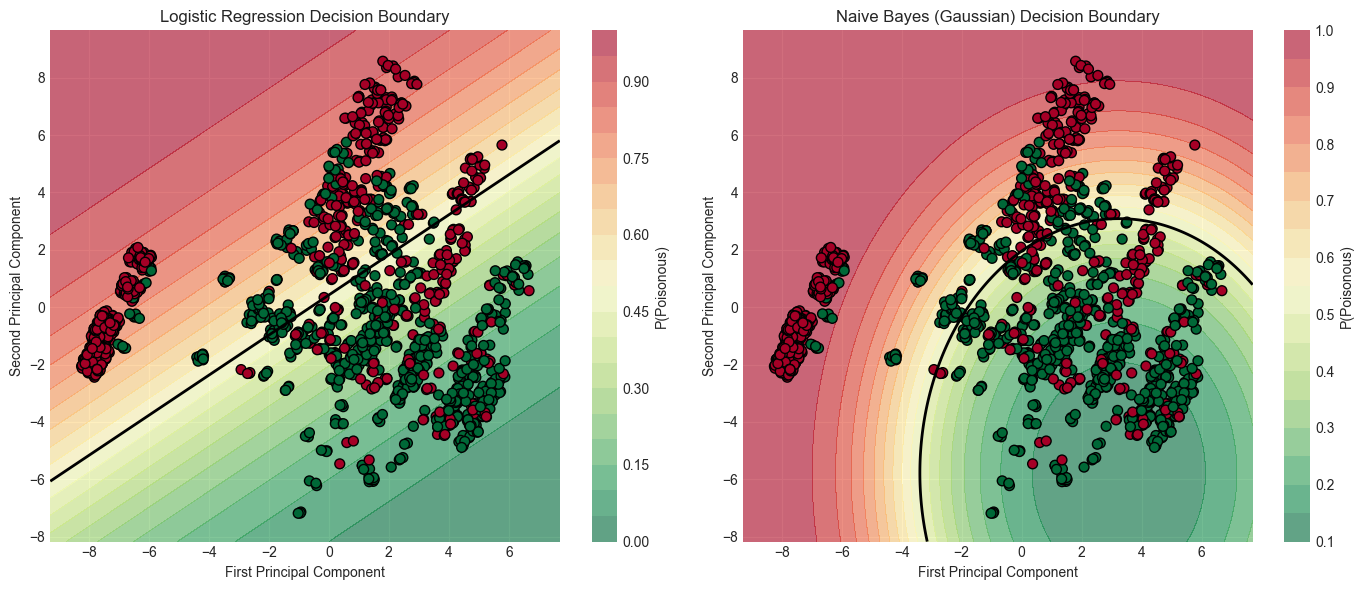

In [157]:
# Visual Decision Boundaries: How They "See" the Data
from sklearn.naive_bayes import GaussianNB  # Add this import at the top

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create a mesh for decision boundary
h = .02  # step size
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Retrain on PCA features for visualization
lr_pca = LogisticRegression(max_iter=1000, random_state=42)
nb_pca = GaussianNB()  # Now this will work
lr_pca.fit(X_pca, y_train)
nb_pca.fit(X_pca, y_train)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for ax, model, title in [(ax1, lr_pca, 'Logistic Regression'), 
                         (ax2, nb_pca, 'Naive Bayes (Gaussian)')]:
    # Decision boundary
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn_r', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot points
    scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                        c=y_test, cmap='RdYlGn_r', edgecolor='black', s=50)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title(f'{title} Decision Boundary')
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('P(Poisonous)')

plt.tight_layout()
plt.show()


The decision boundaries reveal key differences: Logistic Regression creates smooth, linear boundaries in the transformed space, while Naive Bayes can create more complex, non-linear boundaries.


### Logistic Regression vs. Naive Bayes — Key Takeaway

- Naive Bayes is a generative model (models P(X|Y) with a conditional independence assumption). It’s extremely fast and strong on small or high-dimensional data, but correlated features can hurt performance.
- Logistic Regression is a discriminative model (models P(Y|X) directly). It handles correlated features better (especially with regularization) and typically yields better-calibrated probabilities, at the cost of iterative training.
- Both can handle discrete and continuous features: NB has Gaussian/Multinomial/Bernoulli/Categorical variants; LR handles both via appropriate encoding (e.g., one-hot for categorical).

# Part 4: Calibration & Safety
## Model Calibration: Can We Trust These Probabilities?


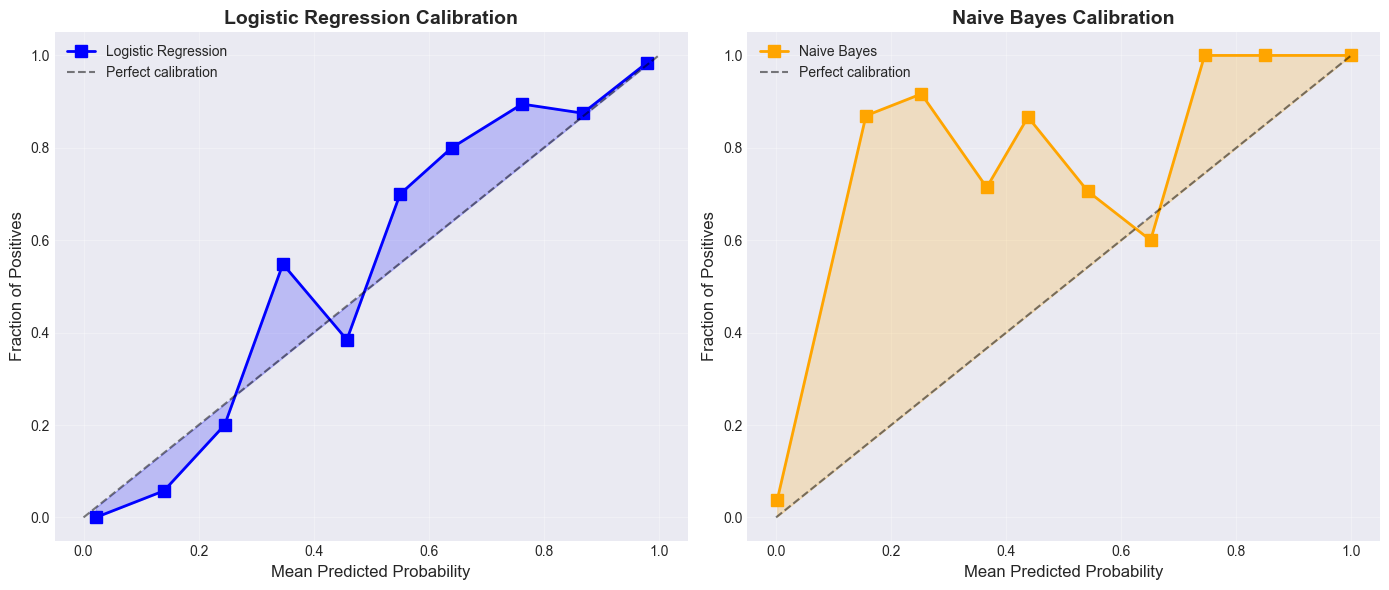

In [158]:
# Calibration Analysis
from sklearn.calibration import calibration_curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for ax, (name, proba, color) in [(ax1, ('Logistic Regression', lr_proba[:, 1], 'blue')),
                                  (ax2, ('Naive Bayes', nb_proba[:, 1], 'orange'))]:
    
    fraction_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10)
    
    # Plot calibration curve
    ax.plot(mean_pred, fraction_pos, 's-', color=color, linewidth=2, 
            markersize=8, label=name)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
    
    # Fill area showing miscalibration
    ax.fill_between(mean_pred, mean_pred, fraction_pos, alpha=0.2, color=color)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title(f'{name} Calibration', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()



**Calibration Interpretation:**
- Points above diagonal → Model is underconfident (too cautious)
- Points below diagonal → Model is overconfident (too certain)
- Distance from diagonal → Calibration error

Well-calibrated models are crucial for risk assessment!

## Interactive Safety Threshold Explorer


In [159]:
# Interactive Safety Threshold Explorer
@widgets.interact(threshold=widgets.FloatSlider(
    value=0.5, min=0.05, max=0.95, step=0.05,
    description='Safety Threshold:',
    style={'description_width': 'initial'}))
def threshold_analysis(threshold):
    # Apply threshold
    lr_pred_thresh = (lr_proba[:, 1] >= threshold).astype(int)
    nb_pred_thresh = (nb_proba[:, 1] >= threshold).astype(int)
    
    # Calculate metrics
    cm_lr = confusion_matrix(y_test, lr_pred_thresh)
    cm_nb = confusion_matrix(y_test, nb_pred_thresh)
    
    # Visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Confusion matrices side by side
    for cm, title, ax in [(cm_lr, 'Logistic Regression', ax1), 
                          (cm_nb, 'Naive Bayes', ax2)]:
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=ax, 
                    xticklabels=['Pred: Edible', 'Pred: Poison'],
                    yticklabels=['True: Edible', 'True: Poison'])
        ax.set_title(f'{title}\n(threshold={threshold:.2f})')
        
        # Highlight false negatives
        rect = plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', linewidth=3)
        ax.add_patch(rect)
    
    # 3. Safety metrics comparison
    metrics = {
        'False Negatives\n(FATAL!)': [cm_lr[1,0], cm_nb[1,0]],
        'False Positives\n(Wasteful)': [cm_lr[0,1], cm_nb[0,1]],
        'Sensitivity\n(Catch poison)': [cm_lr[1,1]/(cm_lr[1,0]+cm_lr[1,1]), 
                                       cm_nb[1,1]/(cm_nb[1,0]+cm_nb[1,1])],
        'Specificity\n(Keep edible)': [cm_lr[0,0]/(cm_lr[0,0]+cm_lr[0,1]), 
                                       cm_nb[0,0]/(cm_nb[0,0]+cm_nb[0,1])]
    }
    
    x = np.arange(len(metrics))
    width = 0.35
    
    for i, (metric, values) in enumerate(metrics.items()):
        bars1 = ax3.bar(i - width/2, values[0], width, label='LR' if i==0 else '', color='blue', alpha=0.7)
        bars2 = ax3.bar(i + width/2, values[1], width, label='NB' if i==0 else '', color='orange', alpha=0.7)
        
        # Highlight false negatives
        if i == 0:
            bars1[0].set_edgecolor('red')
            bars2[0].set_edgecolor('red')
            bars1[0].set_linewidth(3)
            bars2[0].set_linewidth(3)
    
    ax3.set_ylabel('Value')
    ax3.set_title(f'Safety Metrics Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics.keys(), rotation=45, ha='right')
    ax3.legend()
    ax3.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Safety recommendation
    print(f"\n🛡️ SAFETY ANALYSIS at threshold {threshold}:")
    print(f"• Lower threshold = Classify more as poisonous = Safer but more waste")
    print(f"• Current false negative rate: LR={cm_lr[1,0]}, NB={cm_nb[1,0]}")
    if threshold < 0.3:
        print("✅ CONSERVATIVE: Good for real-world use!")
    elif threshold < 0.5:
        print("⚠️  MODERATE: Some risk remains")
    else:
        print("❌ DANGEROUS: Too many poisonous mushrooms might slip through!")

interactive(children=(FloatSlider(value=0.5, description='Safety Threshold:', max=0.95, min=0.05, step=0.05, s…

In mushroom classification, we should err on the side of caution. Move the threshold down to see how we can eliminate false negatives at the cost of more false positives.



## Edge Cases: When Models Disagree

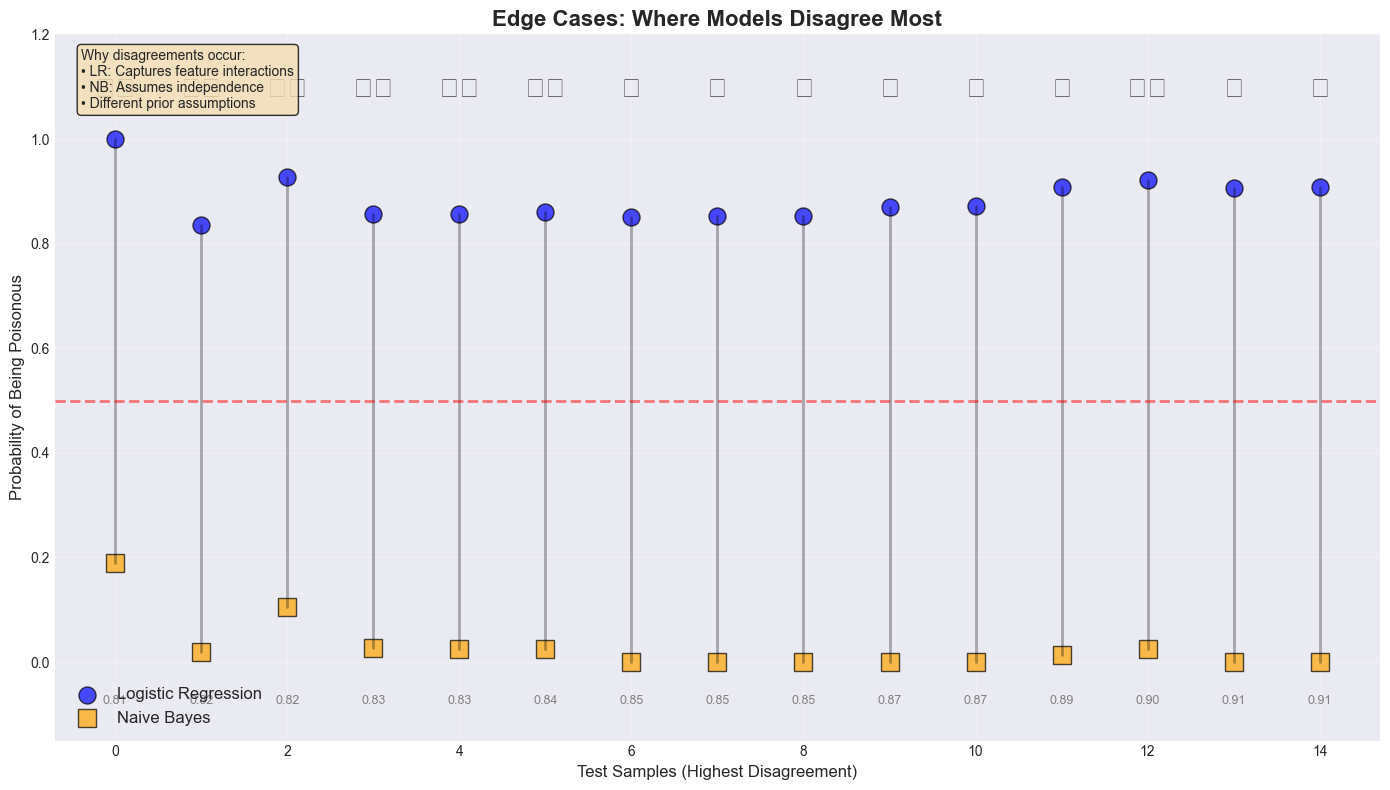

In [160]:
# When Models Disagree: Exploring Edge Cases

# Find disagreements
lr_poison_prob = lr_proba[:, 1]
nb_poison_prob = nb_proba[:, 1]
disagreement = np.abs(lr_poison_prob - nb_poison_prob)

# Get top disagreements
top_disagree_idx = np.argsort(disagreement)[-15:]

# Visualize
plt.figure(figsize=(14, 8))

# Plot setup
x = np.arange(len(top_disagree_idx))
plt.scatter(x, lr_poison_prob[top_disagree_idx], s=150, c='blue', 
           marker='o', label='Logistic Regression', alpha=0.7, edgecolor='black')
plt.scatter(x, nb_poison_prob[top_disagree_idx], s=150, c='orange', 
           marker='s', label='Naive Bayes', alpha=0.7, edgecolor='black')

# Connect disagreements
for i, idx in enumerate(top_disagree_idx):
    plt.plot([i, i], [lr_poison_prob[idx], nb_poison_prob[idx]], 
            'k-', alpha=0.3, linewidth=2)
    
    # True label
    true_label = "☠️" if y_test.iloc[idx] == 1 else "😋"
    plt.text(i, 1.08, true_label, ha='center', fontsize=20)
    
    # Disagreement magnitude
    diff = abs(lr_poison_prob[idx] - nb_poison_prob[idx])
    plt.text(i, -0.08, f'{diff:.2f}', ha='center', fontsize=9, color='gray')

plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
plt.xlabel('Test Samples (Highest Disagreement)', fontsize=12)
plt.ylabel('Probability of Being Poisonous', fontsize=12)
plt.title('Edge Cases: Where Models Disagree Most', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.ylim(-0.15, 1.2)
plt.grid(True, alpha=0.3)

# Add insight box
plt.text(0.02, 0.98, 
         'Why disagreements occur:\n'
         '• LR: Captures feature interactions\n'
         '• NB: Assumes independence\n'
         '• Different prior assumptions',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top',
         fontsize=10)

plt.tight_layout()
plt.show()

Model disagreements reveal where their different assumptions matter most. These edge cases often involve correlated features that violate Naive Bayes's independence assumption.


# Safety Checklist for Probabilistic Classification

## When deploying classification models in critical domains:

### ✓ **Always Check Calibration**
- Are your probabilities trustworthy?
- Use calibration plots before deployment

### ✓ **Tune Threshold by Domain Risk**
- Default 0.5 threshold is rarely optimal
- For mushrooms: err on the side of caution (e.g., 0.2)
- For other domains: balance false positives vs false negatives

### ✓ **Inspect Feature Interactions**
- Naive Bayes assumes independence - verify this!
- Use correlation analysis and domain knowledge
- Consider ensemble approaches when assumptions are violated

### ✓ **Monitor Edge Cases**
- Pay special attention when models disagree
- These often reveal important edge cases
- Consider human review for high-disagreement samples

### ✓ **Communicate Uncertainty**
- Never hide probabilities behind binary decisions
- Always show confidence levels
- Make recommendations, not mandates

# Practice Exercises

## 1. **Feature Engineering Challenge**
Create a "danger score" combining odor, spore-print-color, and habitat. Does it improve classification?

## 2. **Optimal Threshold Search**
Write code to find the threshold that achieves zero false negatives with minimum false positives.

## 3. **Independence Testing**
Systematically test all feature pairs for independence violations. Which pairs hurt Naive Bayes most?

## 4. **Calibration Improvement**
Research and implement Platt scaling or isotonic regression to improve probability calibration.

## 5. **Real-World Extension**
Apply these techniques to another safety-critical dataset (medical diagnosis, fraud detection, etc.)

## Resources:
- UCI ML Repository: Mushroom Dataset